In [12]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [14]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('enwik8.zip', 36445475)


Found and verified enwik8.zip


In [20]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    for name in f.namelist():    
        print('name: %s' % name)
        print('type: %s' % type(name))
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size: %d' % len(words))

name: enwik8
type: <type 'str'>
Data size: 13303056


### Build the dictionary and replace rare words with UNK token.

In [21]:
## exclude words in stoplist
stoplist = set('for a b c d e f g h i j k l m n o p q r s t u v w x y z \
    an th the'.split())

In [22]:
words = [i for i in words if i not in stoplist]
print ('Data size', len(words))

Data size 12243868


In [23]:
vocabulary_size = 50000  # orig 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print ('Most common words (+UNK): ', count[:15])
print ('Sample data (indexes of words): ',  data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK):  [['UNK', 2455983], ('of', 482580), ('and', 320272), ('in', 248527), ('to', 243007), ('is', 142939), ('as', 94840), ('The', 93111), ('by', 84965), ('*', 84229), ('was', 82696), ('that', 82202), ('with', 71011), ('|', 63591), ('on', 63293)]
Sample data (indexes of words):  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Function to generate a training batch for the skip-gram model.

In [24]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']

with num_skips = 2 and skip_window = 1:
    batch: ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']
    labels: ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']

with num_skips = 4 and skip_window = 2:
    batch: ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']
    labels: ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK']


### Look into the data

In [25]:
print (len(data), data[-10:])
print (len(count), count[-10:])

12243868 [914, 120, 4, 19, 609, 3003, 8188, 2242, 681, 27]
50000 [('1.06', 16), ("|''[[The", 16), (':See', 16), ('Cycling', 16), ('Church;', 16), ('doing.', 16), ('jump.', 16), ('steppes', 16), ('architects,', 16), ('G.P.', 16)]


In [30]:
# begining of corpus, with indexes
for i in (data)[500:550]:
    print (reverse_dictionary[i], i)

equal 997
access 875
to 4
UNK 0
UNK 0
UNK 0
UNK 0
Origins 8069
of 1
Family, 43740
Private 8969
UNK 0
and 2
UNK 0
UNK 0
UNK 0
UNK 0
Anarchists 45447
including 117
[[The 353
UNK 0
Organisation]] 24089
and 2
[[Murray 21976
UNK 0
find 558
anarchist 9095
attitudes 8583
in 3
UNK 0
from 16
[[History 830
of 1
UNK 0
UNK 0
UNK 0
Organization 4034
UNK 0
UNK 0
and 2
UNK 0
[[April 1302
14]] 6756
[[2002]] 4379
UNK 0
UNK 0
UNK 0
UNK 0
UNK 0
site 600


In [31]:
# end of corpus, with indexes
for i in (data)[-20:]:
    print (reverse_dictionary[i], i)

to 4
be 19
only 60
dialects 2712
of 1
one 35
language, 1902
but 33
modern 174
scholars 1437
consider 914
them 120
to 4
be 19
separate 609
languages. 3003
Recently, 8188
Standard 2242
Japanese 681
has 27


In [32]:
for i in dictionary.keys()[-5:]:
    print (i, dictionary[i])

entirely, 27325
northerly 31848
enterprises, 41293
*1962 41453
expands 22710


In [33]:
for i in reverse_dictionary.items()[:11]:
    print (i)

(0, 'UNK')
(1, 'of')
(2, 'and')
(3, 'in')
(4, 'to')
(5, 'is')
(6, 'as')
(7, 'The')
(8, 'by')
(9, '*')
(10, 'was')


### Train a skip-gram model.

SKIP-GRAM:
```    
inputs             projection      output

                                /---  w(t-2) 
   w(t)  ___________| sum | ___/----  w(t-1) 
                               \----  w(t+1) 
                                \---  w(t+2)
```

In [34]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size], \
                        stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print (embed.get_shape().as_list())
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed, \
                        labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings/norm
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

[128, 128]


### Run the skip-gram model

In [35]:
num_steps = 100001

with tf.Session(graph=graph) as session:
#   tf.initialize_all_variables().run()
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.218245
Nearest to use: Edition,, synthesize, highlights, tune, Hope, Growth, Meet, ''Book,
Nearest to into: in-depth, [[UN]], overseeing, 1984,, PMID, links|You, Map, well.,
Nearest to many: ensure, Pessoa's, dominance., Household, Yugoslav, Area, 135, Basques,
Nearest to when: autobiography,, Architecture]], did, epoch, top;, successfully., Banner, Recently,
Nearest to <text: approach,, downs, composite, safest, initiative., Maximus, Jellicoe, באפריל]],
Nearest to to: Origen, immature, war]], frivolous, [[Strait, students,, #FFCC66;, Mesopotamia,
Nearest to American: diet., [[1940s]], Lucius, favour., hung, Secret, suburbs,, Otto,
Nearest to in: [[Channel, 1.5, (2006), A]],, [[Category:Women, *[[1874]], crying, sentence,,
Nearest to some: dismay, offered,, ages., *no:, Palestine,, <id>178836</id>, interference, religion]],,
Nearest to or: Theory'', North,, builder, Documents, |align=left, fellowship, Brother, dressed,
Nearest to than: Susie, unive

### Look into the data

In [36]:
print(final_embeddings[0])

[ 0.06836224  0.60020381  0.0176909  -0.1326098   0.03838786 -0.04630347
  0.08171749  0.05807719 -0.11837716  0.04430734 -0.13744108 -0.03934325
  0.00132733  0.02729091  0.06539463  0.11348257  0.09658913  0.1982889
 -0.02304778 -0.0293152   0.05908098 -0.02466188 -0.05481515  0.10325108
 -0.04197518 -0.16946116  0.03147458  0.00488864 -0.05415215 -0.02651818
  0.00433613  0.0240059   0.06562687  0.07199664  0.06621585  0.00671681
 -0.03362704  0.07423654  0.11394719 -0.02061564  0.07066813 -0.16552287
 -0.0134997  -0.01019126 -0.0050574   0.10707542  0.04305314 -0.07276464
 -0.10304005  0.00807026 -0.01505893 -0.01260837 -0.00620249 -0.03437339
  0.03753153 -0.01610709  0.06875542  0.0596531   0.15756695  0.00769357
  0.00430552 -0.18886979 -0.03937025 -0.01916859 -0.08263458  0.00844644
  0.10421005  0.00353413 -0.19149521  0.10225005 -0.06023557 -0.036202
  0.05987519 -0.0098103   0.05389481  0.04458242 -0.0249506   0.01848406
  0.03642374  0.06977101 -0.06174283 -0.03005927 -0.01

All the values are abstract, there is practical meaning of the them. Moreover, the final embeddings are normalized as you can see here:

In [37]:
print(np.sum(np.square(final_embeddings[0])))

1.0


In [38]:
# source: https://discussions.udacity.com/t/assignment-5-error-in-the-main-code-valueerror-array-must-not-contain-infs-or-nans/178187/9
## if error; the problem is from numpy. Fixing it as follows:
### sudo conda remove numpy --force -y
### sudo pip uninstall numpy -y
### conda install numpy

num_points = 400
## t-Distributed Stochastic Neighbor Embedding (t-SNE) 
## is a technique for dimensionality reduction for the visualization of high-dimensional datasets. 
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

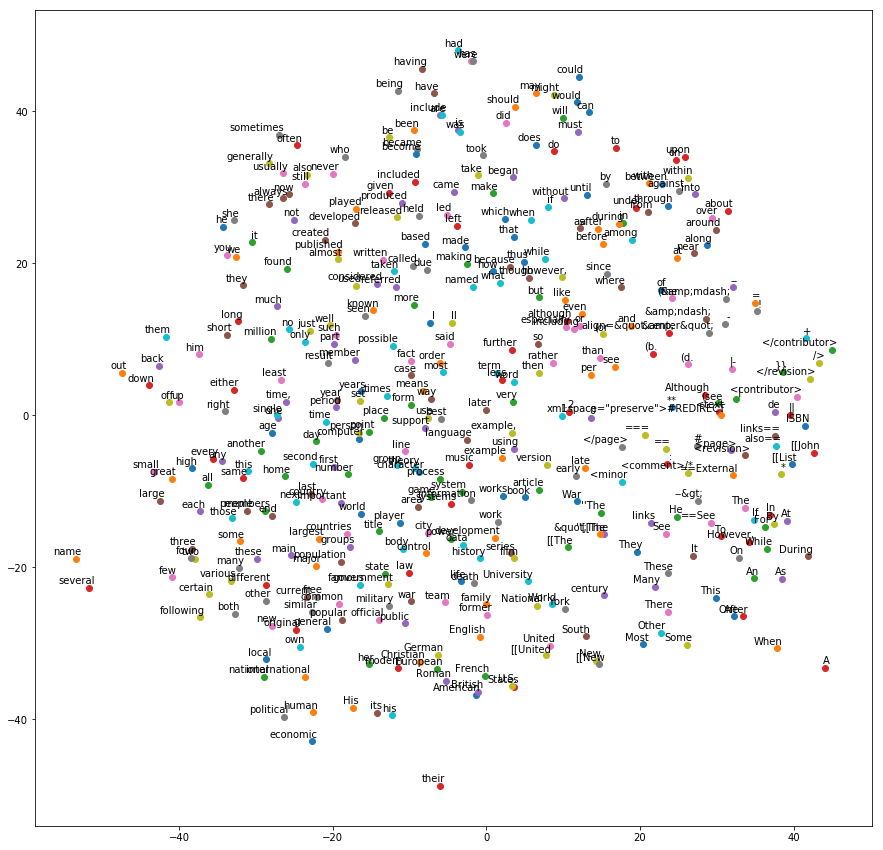

In [39]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

### Problem
An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

[The skip-gram model tutorial](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/).

### Training a CBOW model

Continuous Bag-of-Words Model (CBOW) predicts the current word based on the context.

We have obtained the best performance on the task introduced in the next section by building a log-linear classifier with four future and four history words at the input, where the training criterion is to correctly classify the current (middle) word.

CBOW uses continuous distributed representation of the context. Note that the weight matrix between the input and the projection layer is shared for all word positions in the same way as in the NNLM.

##### CBOW:
```
inputs(embeddings)      projection      output

w(t-2) ---\
w(t-1) -----\____________| sum |__________ w(t)
w(t+1) -----/
w(t+2) ---/
Training complexity: Q = N*D + D*log2(V)
```


In [40]:
data_index = 0

def generate_batch(batch_size, bag_window):
  global data_index
  span = 2 * bag_window + 1 # [ bag_window target bag_window ]
  batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)  
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size):
    # just for testing
    buffer_list = list(buffer)
    labels[i, 0] = buffer_list.pop(bag_window)
    batch[i] = buffer_list
    # iterate to the next buffer
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:16]])

for bag_window in [1, 2]:
  data_index = 0
  batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
  print('\nwith bag_window = %d:' % (bag_window))  
  print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])  
  print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])

data: ['UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', 'UNK', '<namespace', 'UNK']

with bag_window = 1:
    batch: [['UNK', 'UNK'], ['UNK', 'UNK'], ['UNK', 'UNK'], ['UNK', 'UNK']]
    labels: ['UNK', 'UNK', 'UNK', 'UNK']

with bag_window = 2:
    batch: [['UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK'], ['UNK', 'UNK', 'UNK', 'UNK']]
    labels: ['UNK', 'UNK', 'UNK', 'UNK']


### Build the CBOW graph

In [41]:
# Note: In the loss function, exchanged: reduced_embed and train_labels.

batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
# skip_window = 1 # How many words to consider left and right.
###num_skips = 2 # How many times to reuse an input to generate a label.
bag_window = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

    # Model.
    # Look up embeddings for inputs.
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    
    # reduced_embed 
    reduced_embed = tf.div(tf.reduce_sum(embeds, 1), bag_window*2)
    # contruct sum
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the softmax loss, using a sample of the negative labels each time. 
    ## exchanged: reduced_embed and train_labels.
    ### https://stackoverflow.com/a/43787255/2881205
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, train_labels, tf.reduce_sum(embeds, 1),
                                                     num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [42]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.445551
Nearest to then: Justice,, chimpanzees, murderer, +3, fluorescent, (set, Conditioning, (European,
Nearest to been: zu, frost, stimulates, style=&quot;font-size:, charts,, vandalism, achievement., goddesses]],
Nearest to number: \{, ''[[List, [[geometry]], attention., Scripture, grid, unique, [[1834]],
Nearest to many: ongoing, Comics', pronunciation,, [[1946]]., population|Ranked, Cor, shelf, Secondly,,
Nearest to he: lightweight, Willis, morning,, writers., criticizing, predominant, &lt;/div&gt;, 1997),
Nearest to often: [[1847]], ==Footnotes==, [[Corpus, Abrahamic, {{Persondata, Error, *[[Adam, 1),
Nearest to on: template., \left[, Libraries, varied, adjoining, Adults, turbine, read/write,
Nearest to which: norm,, cocktail, :Total, [[Hawaii]],, wins,, fl, size, Bing,
Nearest to after: travel., result,, 1952., nets, personnel, [[collective, weapon]]s, themes,
Nearest to be: 5.8, wedge, match,, mistake, topics==, resembles, overlap., [[Categ

In [43]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

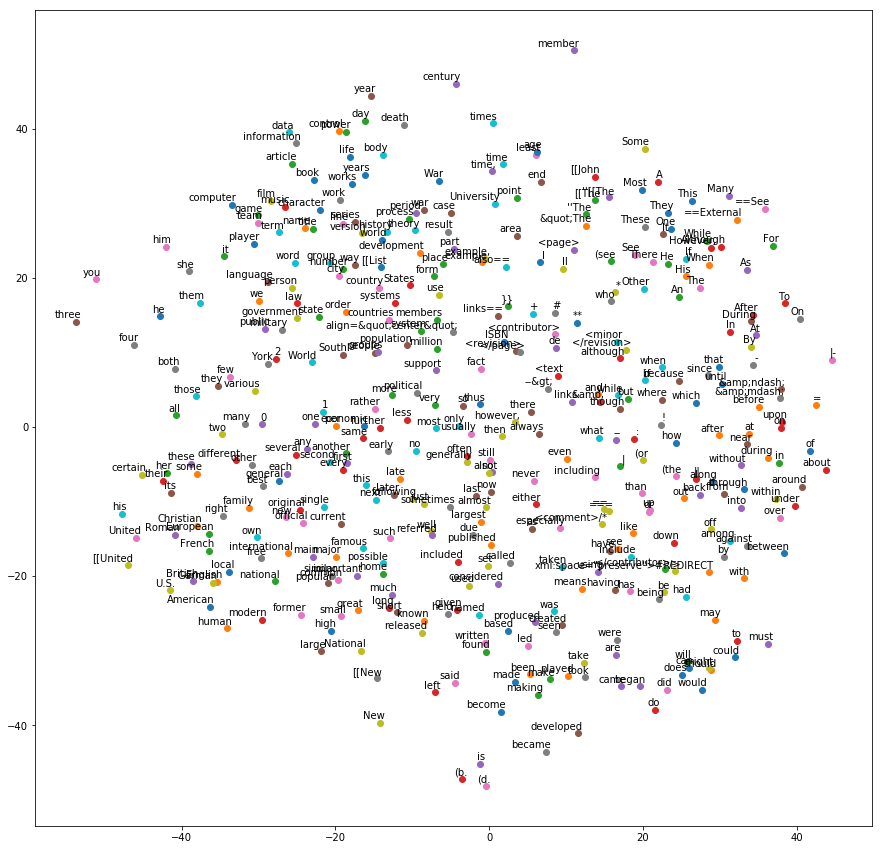

In [44]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

* Conlusion: There are the same results as text8.zip, with enwik8.zip wikipedia dataset, CBOW model is also more compact than skip-gram model, as it predicts the target based on the context, while SKIP-GRAM model predicts surrounding words given the current word.